This file contains the work to generate core users and feeding it to IDCF codebase for amazon beauty ratings dataset.
- greater than 30 interactions are taken into.
- Less than 30 interations are taken into test set
- some x% of coreusers are choosen as training set
- coreusers are calculated using CUR decomposition and R matrix is taken as coreuser.
- always the results are tested on test set.

In [16]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle

- code to read and clean douban book review file.

In [19]:
ml1m_dir = 'data/ratings_Beauty.csv'
# ml1m_rating = pd.read_csv(ml1m_dir, sep=',',index_col=0, engine='python')
ml1m_rating = pd.read_csv(ml1m_dir, sep=',', usecols=range(3), names=['uid', 'mid', 'rating'], header=None)
# df = ml1m_rating[["user_id", book_id", "rating", "time"]]
# ml1m_rating.head()
df = ml1m_rating.groupby('uid').filter(lambda x : len(x)>10)
# df = df.groupby('mid').filter(lambda x : len(x)>10)
df = df.groupby('mid').filter(lambda x : len(x)>5)
print("UID LEN:", len(np.unique(df['uid'])))
print("MID LEN:", len(np.unique(df['mid'])))
print("LEN OF DF:", len(df))
# ml1m_rating.to_csv('data/ratings_Beauty_new.csv', index=False)


UID LEN: 10150
MID LEN: 6079
LEN OF DF: 101635


In [20]:
# print(len(df))
df.to_csv('data/ratings_Beauty_new.csv', index=False)

In [15]:
def ReadData(threshold=30):
    # uncomment this line for movielens dataset
    ml1m_dir = 'data/ratings_Beauty_new.csv'
    ml1m_rating = pd.read_csv(ml1m_dir, sep=',', usecols=range(3), header=None, names=['uid', 'mid', 'rating'],  engine='python')
    # use the below 2 lines for pinterest dataset.
    # ml1m_dir = 'data/pin-interest-main.txt'
    # ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')

    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    v = tmp_df.uid.value_counts()
    df = tmp_df[tmp_df.uid.isin(v.index[v.gt(threshold)])]
### code to store less than 30 interactions:
    df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(threshold)])]
    return df, df_less_30, len(np.unique(mid_list)), len(unique_uid)

In [6]:
THRESHOLD = 5 #split the users into test and train by threshold number of interactions. if greater than threshold then all interactions of that user goes into train set.
df_gt_30, df_le_30, unique_mids, unique_uids = ReadData(THRESHOLD)
print("GREATER THAN 30:\n", df_gt_30)
print("LESS THAN 30: \n", df_le_30)
print("GREATER THAN THRESHOLD: ", len(df_gt_30))
print("LESS THAN THRESHOLD: " ,len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)
print("UNIQUE UIDS: ", unique_uids)

DICTIONARY PREPARED:
GREATER THAN 30:
          uid   mid ratings
1       3880     0     5.0
2       5498     0     3.0
3       7650     0     5.0
4       9781     0     5.0
5       3977     0     5.0
...      ...   ...     ...
101629  7157  6078     5.0
101630  3573  6078     5.0
101631  2267  6078     5.0
101632  5849  6078     5.0
101634  7017  6078     5.0

[90182 rows x 3 columns]
LESS THAN 30: 
           uid   mid ratings
0       10150  6079  rating
8        5757     1     5.0
9       10028     1     5.0
14       9488     1     4.0
22       6259     2     5.0
...       ...   ...     ...
100306   4516  6022     3.0
100839   1199  6045     5.0
101469   2875  6066     4.0
101633   4512  6078     5.0
101635   9609  6078     5.0

[11454 rows x 3 columns]
GREATER THAN THRESHOLD:  90182
LESS THAN THRESHOLD:  11454
UNIQUE MIDS:  6080
UNIQUE UIDS:  10151


In [7]:
support_test_df = df_gt_30.groupby("uid").tail(1)
# print(len(df_gt_30['uid']))
support_train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_gt_30)== len(support_test_df) + len(support_train_df))
# print(len(test_df))
# print(len(train_df))
query_test_df = df_le_30.groupby("uid").tail(1)
query_train_df = df_le_30.drop(df_le_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_le_30)== len(query_test_df) + len(query_train_df))
dic_support_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(support_train_df['uid']))])
dic_support_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(support_train_df['uid']))])
### no need for mid mapping

uid_of_train_df = support_train_df['uid'].tolist()
for i in range(len(uid_of_train_df)):
    uid_of_train_df[i] = dic_support_train_df_uid_mapping[uid_of_train_df[i]]
# for index, row in train_df.iterrows():
#     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':support_train_df['mid'], 'ratings':support_train_df['ratings']})
print("NUMBER OF USERS IN SUPPORT TEST:", len(np.unique(support_test_df['uid'])))
print("NUMBER OF USERS IN SUPPORT TRAIN", len(np.unique(support_train_df['uid'])))
print("NUMBER OF USERS IN QUERY TEST:", len(np.unique(query_test_df['uid'])))
print("NUMBER OF USERS IN QUERY TRAIN", len(np.unique(query_train_df['uid'])))

NUMBER OF USERS IN SUPPORT TEST: 6864
NUMBER OF USERS IN SUPPORT TRAIN 6864
NUMBER OF USERS IN QUERY TEST: 3287
NUMBER OF USERS IN QUERY TRAIN 2986


In [8]:
train_ui_dic = {}    
for user in range(unique_uids):
    train_ui_dic[user] = []
for index,row in support_train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

- utility functions for CUR coreusers.

In [9]:
MAX_MID = 27277 + 1
def select_cols(mat, k, dup=False):
    # prob 1d array of probabilities of all columns
    prob = mat.T.dot(mat)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis = 0)
    prob = prob/denom

    C = np.zeros((mat.shape[0], k))
    ind_cols = np.arange(0, prob.size)
    c_ind = []
    i = 0
    while(i < k):
        rand_sel = np.random.choice(ind_cols, 1, p=prob)
        if rand_sel in c_ind:
            continue
        c_ind.append(rand_sel[0])
        C[:, i] = mat[:, rand_sel[0]]
        i += 1
        # C[:, i] = C[:, i]/np.sqrt(k*prob[rand_sel[0]])

    return C, c_ind

def select_rows(mat, k, dup=False):

    prob = mat.dot(mat.T)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis=0)
    prob = prob/denom
    print(prob)
    r = np.zeros((k, mat.shape[1]))
    ind_rows = np.arange(0, prob.size)
    r_ind = []
    i = 0
    while(i < k):
        # print(ind_rows)
        rand_sel = np.random.choice(ind_rows, 1, p=prob)
        if rand_sel in r_ind:
            continue
        r_ind.append(rand_sel[0])
        r[i, :] = mat[rand_sel[0], :]
        i += 1
        # r[i, :] = r[i, :]/np.sqrt(k*prob[rand_sel[0]])
    r_ind = np.array(r_ind)
    return r, r_ind

# def matIntersection(mat, c_ind, r_ind):
    
#     W = np.zeros((len(r_ind), len(c_ind)))
#     for i in range(len(r_ind)):
#         W[i] = mat[r_ind[i], c_ind]
    
#     return W

# def pseudoInverse(W):
#     # U = WP (W+)

#     # W = X.Z.YT
#     X, Z, YT = np.linalg.svd(W)
    
#     # W+ = Y.Z+.XT
#     XT = X.T
#     Y = YT.T
#     # Z+ = reciprocal(Z)
#     ZP = np.reciprocal(Z)
#     ZP = sp.spdiags(ZP, 0, ZP.size, ZP.size)
#     ZP = ZP@ZP
    
#     # W+ = Y.Z+.XT
#     WP = Y@ZP
#     WP = WP@XT

#     return WP

In [10]:
def ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    # print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    # print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    # print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    # print("TWENTY PERCENT USER:", (twentyPercentUserList))
    coreusers = dataframe.iloc[np.where(dataframe.uid.isin(twentyPercentUserList))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return coreusers

In [11]:
def CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    C, c_ind = select_cols(mat, int(u_len * 0.10)) ## getting 20% core users
    r, r_ind= select_rows(mat, int(u_len * 0.10))
    print("r", r)
    print("r_ind len", len(r_ind))

    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(r_ind))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return cur_coreusers

In [12]:
# core_users = CUR_ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
core_users = ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
support_user_list = np.unique(core_users['uid'])
print("CORE USERS:" ,core_users)
print("NUMBER OF CORE USERS:", len(support_user_list))

USER LEN: 6864
MOVIE LEN: 6080
USER ITEM MATRIX: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
SHAPE OF COSINE MATIX:
  (6864, 6864)
CORE USERS:          uid   mid ratings
20       502     1     2.0
23      3218     2     3.0
28      2103     2     5.0
42      5067     3     5.0
49      5802     5     2.0
...      ...   ...     ...
101583    88  6073     5.0
101588  1588  6074     5.0
101594  6691  6074     5.0
101600  4851  6075     5.0
101602  1505  6075     5.0

[18846 rows x 3 columns]
NUMBER OF CORE USERS: 1372


In [33]:
print(len(support_user_list))
len(np.unique(uid_of_train_df))
# print()

523


5231

In [13]:
core_users_index_list = core_users.index.to_list()
# non_core_user_index = (train_df.index.difference(core_users.index))
# non_core_user_index = non_core_user_index.tolist()

core_users_df = support_train_df.loc[core_users_index_list]
# non_core_user_df = train_df.loc[non_core_user_index]
# print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:" ,core_users)

CORE USERS:          uid   mid ratings
20       502     1     2.0
23      3218     2     3.0
28      2103     2     5.0
42      5067     3     5.0
49      5802     5     2.0
...      ...   ...     ...
101583    88  6073     5.0
101588  1588  6074     5.0
101594  6691  6074     5.0
101600  4851  6075     5.0
101602  1505  6075     5.0

[18846 rows x 3 columns]


In [38]:
# print("TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:\n" ,test_df)
# print(core_users['uid'])
unique_uids_in_support_trian = np.unique(np.array(core_users_df['uid']))
unique_uids_in_query_trian = np.unique(query_train_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = support_test_df.loc[support_test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = query_test_df
print("QUERY TEST DF:\n", query_test_df)

274
SUPPORT TEST DF:          uid    mid  ratings
284      613   6169        4
377     2024  83209        1
8073    1920  72451        3
9197     306   2331        5
9499    1447   1785        5
...      ...    ...      ...
225378  1965  31437        5
225529  1701   9819        2
226241  1740  72519        5
226689  1348   6066        5
226841   837  43146        1

[274 rows x 3 columns]
QUERY TEST DF:
          uid    mid  ratings
295     1707  87421        5
299     1620  18452        4
302     1889  74757        4
307      447  75026        4
346       70  69124        5
...      ...    ...      ...
225124   782  24626        5
225541   658  74333        5
226250  1958  29817        3
226261  1170  69547        4
226705  1960   5762        4

[841 rows x 3 columns]


In [39]:
support_train = []
for index,row in core_users_df.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in query_train_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df['uid']).tolist()

In [40]:
import pickle
with open("douban_cos_10_support_as_core.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

- 10% amabeauty cos coreusers into IDCF

In [24]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 9966/8167
test set size: support/query 686/3286
Epoch 0 Step 10: Train 16.6957 Reg: 1.2300
Test: 16.9410 MAE: 3.9313 RMSE: 4.1159
Val: 17.6960 MAE: 4.0785 RMSE: 4.2067
Epoch 1 Step 20: Train 16.1553 Reg: 0.9123
Test: 16.4005 MAE: 3.8619 RMSE: 4.0497
Val: 17.1052 MAE: 4.0056 RMSE: 4.1358
Epoch 2 Step 30: Train 15.5788 Reg: 0.6502
Test: 15.8023 MAE: 3.7837 RMSE: 3.9752
Val: 16.4377 MAE: 3.9216 RMSE: 4.0543
Epoch 3 Step 40: Train 14.9028 Reg: 0.4424
Test: 15.0923 MAE: 3.6888 RMSE: 3.8849
Val: 15.6220 MAE: 3.8166 RMSE: 3.9525
Epoch 4 Step 50: Train 14.0581 Reg: 0.3009
Test: 14.2176 MAE: 3.5685 RMSE: 3.7706
Val: 14.5857 MAE: 3.6791 RMSE: 3.8191
Epoch 5 Step 60: Train 12.9798 Reg: 0.2581
Test: 13.1402 MAE: 3.4143 RMSE: 3.6249
Val: 13.2812 MAE: 3.4982 RMSE: 3.6443
Epoch 6 Step 70: Train 11.6406 Reg: 0.2489
Test: 11.8564 MAE: 3.2208 RMSE: 3.4433
Val: 11.7090 MAE: 3.2671 RMSE: 3.

- 20% amabeauty cos coreusers to IDCF

In [23]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 18846/8167
test set size: support/query 1372/3286
Epoch 0 Step 18: Train 18.4154 Reg: 1.1062
Test: 17.7735 MAE: 4.0486 RMSE: 4.2159
Val: 18.3831 MAE: 4.1556 RMSE: 4.2876
Epoch 1 Step 36: Train 17.2717 Reg: 0.6179
Test: 16.5198 MAE: 3.8907 RMSE: 4.0645
Val: 16.9922 MAE: 3.9849 RMSE: 4.1222
Epoch 2 Step 54: Train 15.5589 Reg: 0.3519
Test: 14.5583 MAE: 3.6299 RMSE: 3.8155
Val: 14.6890 MAE: 3.6848 RMSE: 3.8326
Epoch 3 Step 72: Train 12.7000 Reg: 0.3456
Test: 11.5460 MAE: 3.1890 RMSE: 3.3979
Val: 11.0690 MAE: 3.1600 RMSE: 3.3270
Epoch 4 Step 90: Train 8.7734 Reg: 0.4314
Test: 7.9667 MAE: 2.6198 RMSE: 2.8225
Val: 6.9708 MAE: 2.4618 RMSE: 2.6402
Epoch 5 Step 108: Train 5.1627 Reg: 0.5328
Test: 5.0856 MAE: 2.0618 RMSE: 2.2551
Val: 4.0127 MAE: 1.8306 RMSE: 2.0032
Epoch 6 Step 126: Train 2.9606 Reg: 0.6177
Test: 3.4061 MAE: 1.6696 RMSE: 1.8456
Val: 2.5024 MAE: 1.4328 RMSE: 1.5819


- 40% amabeauty cos core user as input to IDCF

In [22]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 34653/8167
test set size: support/query 2745/3286
Epoch 0 Step 33: Train 17.6140 Reg: 0.9094
Test: 16.7381 MAE: 3.9219 RMSE: 4.0912
Val: 16.8545 MAE: 3.9607 RMSE: 4.1054
Epoch 1 Step 66: Train 14.5820 Reg: 0.4164
Test: 12.4931 MAE: 3.3363 RMSE: 3.5346
Val: 11.8828 MAE: 3.2750 RMSE: 3.4471
Epoch 2 Step 99: Train 8.0040 Reg: 0.5863
Test: 5.7344 MAE: 2.2037 RMSE: 2.3947
Val: 4.4262 MAE: 1.9192 RMSE: 2.1038
Epoch 3 Step 132: Train 2.6632 Reg: 0.8377
Test: 2.5255 MAE: 1.4274 RMSE: 1.5892
Val: 1.7080 MAE: 1.1450 RMSE: 1.3069
Epoch 4 Step 165: Train 1.3101 Reg: 0.9649
Test: 1.7746 MAE: 1.1599 RMSE: 1.3321
Val: 1.2392 MAE: 0.9405 RMSE: 1.1132
Epoch 5 Step 198: Train 1.0569 Reg: 1.0017
Test: 1.5825 MAE: 1.0795 RMSE: 1.2580
Val: 1.1391 MAE: 0.8876 RMSE: 1.0673
Epoch 6 Step 231: Train 0.9726 Reg: 1.0065
Test: 1.5153 MAE: 1.0470 RMSE: 1.2310
Val: 1.0980 MAE: 0.8611 RMSE: 1.0478
Epoc

- 60% amabeauty cos coreusers input to IDCF look into file amabeauty_cos_604654.out for resutls

In [21]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 50207/8167
test set size: support/query 4118/3286
Epoch 0 Step 47: Train 17.4961 Reg: 0.7831
Test: 15.3890 MAE: 3.7479 RMSE: 3.9229
Val: 15.3848 MAE: 3.7692 RMSE: 3.9224
Epoch 1 Step 94: Train 10.7281 Reg: 0.5842
Test: 6.4871 MAE: 2.3504 RMSE: 2.5470
Val: 5.4031 MAE: 2.1415 RMSE: 2.3244
Epoch 2 Step 141: Train 2.7859 Reg: 1.0054
Test: 2.1349 MAE: 1.3040 RMSE: 1.4611
Val: 1.5571 MAE: 1.0810 RMSE: 1.2478
Epoch 3 Step 188: Train 1.2418 Reg: 1.1797
Test: 1.5706 MAE: 1.0793 RMSE: 1.2532
Val: 1.1998 MAE: 0.9105 RMSE: 1.0953
Epoch 4 Step 235: Train 1.0636 Reg: 1.1914
Test: 1.4714 MAE: 1.0295 RMSE: 1.2130
Val: 1.1390 MAE: 0.8715 RMSE: 1.0672
Epoch 5 Step 282: Train 0.9849 Reg: 1.1696
Test: 1.4378 MAE: 1.0097 RMSE: 1.1991
Val: 1.1043 MAE: 0.8493 RMSE: 1.0509
Epoch 6 Step 329: Train 0.9192 Reg: 1.1447
Test: 1.4214 MAE: 0.9955 RMSE: 1.1922
Val: 1.0795 MAE: 0.8303 RMSE: 1.0390
Epoch

- 80% amabeauty cos into IDCF

In [20]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 67321/8167
test set size: support/query 5491/3286
Epoch 0 Step 63: Train 17.3432 Reg: 0.6852
Test: 14.0404 MAE: 3.5582 RMSE: 3.7471
Val: 13.7897 MAE: 3.5483 RMSE: 3.7135
Epoch 1 Step 126: Train 7.0654 Reg: 0.8260
Test: 2.9799 MAE: 1.5645 RMSE: 1.7262
Val: 2.2302 MAE: 1.3352 RMSE: 1.4934
Epoch 2 Step 189: Train 1.4435 Reg: 1.2862
Test: 1.5894 MAE: 1.0835 RMSE: 1.2607
Val: 1.2337 MAE: 0.9230 RMSE: 1.1107
Epoch 3 Step 252: Train 1.1119 Reg: 1.3196
Test: 1.4757 MAE: 1.0265 RMSE: 1.2148
Val: 1.1464 MAE: 0.8699 RMSE: 1.0707
Epoch 4 Step 315: Train 1.0110 Reg: 1.2769
Test: 1.4352 MAE: 1.0018 RMSE: 1.1980
Val: 1.0981 MAE: 0.8376 RMSE: 1.0479
Epoch 5 Step 378: Train 0.9356 Reg: 1.2359
Test: 1.4187 MAE: 0.9841 RMSE: 1.1911
Val: 1.0781 MAE: 0.8158 RMSE: 1.0383
Epoch 6 Step 441: Train 0.8842 Reg: 1.1998
Test: 1.4012 MAE: 0.9648 RMSE: 1.1837
Val: 1.0725 MAE: 0.7990 RMSE: 1.0356
Epoch

- 100% amabeauty cos to IDCF

In [18]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 83318/8167
test set size: support/query 6864/3286
Epoch 0 Step 78: Train 15.4740 Reg: 0.7007
Test: 9.6918 MAE: 2.9068 RMSE: 3.1132
Val: 9.0655 MAE: 2.8177 RMSE: 3.0109
Epoch 1 Step 156: Train 3.4401 Reg: 1.1453
Test: 1.7005 MAE: 1.1380 RMSE: 1.3040
Val: 1.3942 MAE: 1.0032 RMSE: 1.1808
Epoch 2 Step 234: Train 1.1879 Reg: 1.4072
Test: 1.4420 MAE: 1.0137 RMSE: 1.2008
Val: 1.2179 MAE: 0.9023 RMSE: 1.1036
Epoch 3 Step 312: Train 1.0479 Reg: 1.3507
Test: 1.3898 MAE: 0.9823 RMSE: 1.1789
Val: 1.1583 MAE: 0.8670 RMSE: 1.0763
Epoch 4 Step 390: Train 0.9593 Reg: 1.2931
Test: 1.3629 MAE: 0.9552 RMSE: 1.1674
Val: 1.1349 MAE: 0.8412 RMSE: 1.0653
Epoch 5 Step 468: Train 0.9052 Reg: 1.2382
Test: 1.3472 MAE: 0.9351 RMSE: 1.1607
Val: 1.1305 MAE: 0.8248 RMSE: 1.0632
Epoch 6 Step 546: Train 0.8716 Reg: 1.1855
Test: 1.3417 MAE: 0.9196 RMSE: 1.1583
Val: 1.1320 MAE: 0.8129 RMSE: 1.0640
Epoch 7

- 10% amabeauty cur input to IDCF

In [17]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 13764/8167
test set size: support/query 686/3286
Epoch 0 Step 13: Train 18.1347 Reg: 1.1835
Test: 17.5191 MAE: 4.0211 RMSE: 4.1856
Val: 18.0944 MAE: 4.1223 RMSE: 4.2537
Epoch 1 Step 26: Train 17.3358 Reg: 0.7986
Test: 16.6955 MAE: 3.9173 RMSE: 4.0860
Val: 17.2157 MAE: 4.0142 RMSE: 4.1492
Epoch 2 Step 39: Train 16.3551 Reg: 0.5106
Test: 15.6257 MAE: 3.7784 RMSE: 3.9529
Val: 16.0467 MAE: 3.8658 RMSE: 4.0058
Epoch 3 Step 52: Train 14.9869 Reg: 0.3491
Test: 14.1385 MAE: 3.5761 RMSE: 3.7601
Val: 14.3783 MAE: 3.6434 RMSE: 3.7919
Epoch 4 Step 65: Train 13.0521 Reg: 0.3383
Test: 12.1392 MAE: 3.2845 RMSE: 3.4841
Val: 12.1088 MAE: 3.3182 RMSE: 3.4798
Epoch 5 Step 78: Train 10.5668 Reg: 0.3804
Test: 9.7534 MAE: 2.9206 RMSE: 3.1230
Val: 9.4195 MAE: 2.9105 RMSE: 3.0691
Epoch 6 Step 91: Train 7.8673 Reg: 0.4415
Test: 7.3639 MAE: 2.5129 RMSE: 2.7137
Val: 6.8036 MAE: 2.4524 RMSE: 2.6084

- 20% amabeauty cur as input to IDCF

In [16]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 25362/8167
test set size: support/query 1372/3286
Epoch 0 Step 24: Train 18.2742 Reg: 1.0238
Test: 17.4741 MAE: 4.0241 RMSE: 4.1802
Val: 17.5896 MAE: 4.0631 RMSE: 4.1940
Epoch 1 Step 48: Train 16.4727 Reg: 0.4763
Test: 15.3004 MAE: 3.7443 RMSE: 3.9116
Val: 15.2359 MAE: 3.7619 RMSE: 3.9033
Epoch 2 Step 72: Train 13.2808 Reg: 0.3914
Test: 11.4672 MAE: 3.1954 RMSE: 3.3863
Val: 10.9499 MAE: 3.1442 RMSE: 3.3091
Epoch 3 Step 96: Train 8.3418 Reg: 0.5291
Test: 6.7051 MAE: 2.4096 RMSE: 2.5894
Val: 5.8800 MAE: 2.2492 RMSE: 2.4249
Epoch 4 Step 120: Train 4.1259 Reg: 0.6927
Test: 3.5921 MAE: 1.7397 RMSE: 1.8953
Val: 2.9282 MAE: 1.5496 RMSE: 1.7112
Epoch 5 Step 144: Train 2.1658 Reg: 0.8066
Test: 2.2723 MAE: 1.3684 RMSE: 1.5074
Val: 1.8044 MAE: 1.2084 RMSE: 1.3433
Epoch 6 Step 168: Train 1.4522 Reg: 0.8659
Test: 1.7435 MAE: 1.1777 RMSE: 1.3204
Val: 1.3872 MAE: 1.0236 RMSE: 1.1778
Ep

- 40%  amabeauty cur coreuser as input to IDCF

In [15]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 45122/8167
test set size: support/query 2745/3286
Epoch 0 Step 42: Train 17.3399 Reg: 0.8227
Test: 15.4956 MAE: 3.7686 RMSE: 3.9364
Val: 15.8913 MAE: 3.8538 RMSE: 3.9864
Epoch 1 Step 84: Train 11.6577 Reg: 0.5212
Test: 7.6315 MAE: 2.5736 RMSE: 2.7625
Val: 6.9746 MAE: 2.4656 RMSE: 2.6410
Epoch 2 Step 126: Train 3.4145 Reg: 0.8720
Test: 2.2251 MAE: 1.3380 RMSE: 1.4917
Val: 1.7304 MAE: 1.1549 RMSE: 1.3154
Epoch 3 Step 168: Train 1.2675 Reg: 1.0673
Test: 1.4971 MAE: 1.0479 RMSE: 1.2236
Val: 1.1770 MAE: 0.9117 RMSE: 1.0849
Epoch 4 Step 210: Train 1.0575 Reg: 1.0985
Test: 1.3759 MAE: 0.9879 RMSE: 1.1730
Val: 1.0868 MAE: 0.8593 RMSE: 1.0425
Epoch 5 Step 252: Train 0.9725 Reg: 1.0899
Test: 1.3228 MAE: 0.9606 RMSE: 1.1501
Val: 1.0384 MAE: 0.8313 RMSE: 1.0190
Epoch 6 Step 294: Train 0.9064 Reg: 1.0762
Test: 1.2900 MAE: 0.9401 RMSE: 1.1358
Val: 1.0068 MAE: 0.8103 RMSE: 1.0034
Epoch

- 60% cur amaelec as input to IDCF

In [14]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 60444/8167
test set size: support/query 4118/3286
Epoch 0 Step 57: Train 16.8225 Reg: 0.7233
Test: 14.1322 MAE: 3.5810 RMSE: 3.7593
Val: 13.8641 MAE: 3.5607 RMSE: 3.7235
Epoch 1 Step 114: Train 7.9395 Reg: 0.7323
Test: 3.5520 MAE: 1.7226 RMSE: 1.8847
Val: 2.8223 MAE: 1.5152 RMSE: 1.6800
Epoch 2 Step 171: Train 1.6071 Reg: 1.1789
Test: 1.5338 MAE: 1.0696 RMSE: 1.2385
Val: 1.2578 MAE: 0.9378 RMSE: 1.1215
Epoch 3 Step 228: Train 1.0989 Reg: 1.2518
Test: 1.3758 MAE: 0.9892 RMSE: 1.1729
Val: 1.1491 MAE: 0.8713 RMSE: 1.0720
Epoch 4 Step 285: Train 1.0012 Reg: 1.2239
Test: 1.3305 MAE: 0.9639 RMSE: 1.1535
Val: 1.0923 MAE: 0.8405 RMSE: 1.0451
Epoch 5 Step 342: Train 0.9250 Reg: 1.1877
Test: 1.3023 MAE: 0.9426 RMSE: 1.1412
Val: 1.0586 MAE: 0.8150 RMSE: 1.0289
Epoch 6 Step 399: Train 0.8704 Reg: 1.1556
Test: 1.2835 MAE: 0.9217 RMSE: 1.1329
Val: 1.0403 MAE: 0.7921 RMSE: 1.0200
Epoch

- 80% amabeauty cur coreuser input to IDCF

In [13]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 72994/8167
test set size: support/query 5491/3286
Epoch 0 Step 68: Train 16.2277 Reg: 0.6851
Test: 11.9726 MAE: 3.2642 RMSE: 3.4601
Val: 11.5480 MAE: 3.2193 RMSE: 3.3982
Epoch 1 Step 136: Train 5.2669 Reg: 0.9434
Test: 2.1664 MAE: 1.3215 RMSE: 1.4719
Val: 1.6981 MAE: 1.1426 RMSE: 1.3031
Epoch 2 Step 204: Train 1.2731 Reg: 1.3329
Test: 1.4238 MAE: 1.0132 RMSE: 1.1932
Val: 1.1974 MAE: 0.8998 RMSE: 1.0943
Epoch 3 Step 272: Train 1.0686 Reg: 1.3232
Test: 1.3415 MAE: 0.9697 RMSE: 1.1583
Val: 1.1263 MAE: 0.8575 RMSE: 1.0613
Epoch 4 Step 340: Train 0.9750 Reg: 1.2689
Test: 1.3066 MAE: 0.9450 RMSE: 1.1431
Val: 1.0875 MAE: 0.8296 RMSE: 1.0428
Epoch 5 Step 408: Train 0.9082 Reg: 1.2189
Test: 1.2832 MAE: 0.9233 RMSE: 1.1328
Val: 1.0688 MAE: 0.8084 RMSE: 1.0338
Epoch 6 Step 476: Train 0.8639 Reg: 1.1730
Test: 1.2685 MAE: 0.9031 RMSE: 1.1263
Val: 1.0599 MAE: 0.7903 RMSE: 1.0295
Epoch

- 100% support user as cos core user to IDCF

In [33]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 94119/4938
test set size: support/query 730/213
Epoch 0 Step 88: Train 5.7745 Reg: 0.4774
Test: 1.1326 MAE: 0.8667 RMSE: 1.0642
Val: 1.1027 MAE: 0.8496 RMSE: 1.0501
Epoch 1 Step 176: Train 0.9613 Reg: 0.4771
Test: 0.9707 MAE: 0.7764 RMSE: 0.9852
Val: 0.9213 MAE: 0.7650 RMSE: 0.9599
Epoch 2 Step 264: Train 0.8752 Reg: 0.4516
Test: 0.9511 MAE: 0.7680 RMSE: 0.9753
Val: 0.8905 MAE: 0.7500 RMSE: 0.9436
Epoch 3 Step 352: Train 0.8573 Reg: 0.4304
Test: 0.9398 MAE: 0.7625 RMSE: 0.9695
Val: 0.8809 MAE: 0.7444 RMSE: 0.9385
Epoch 4 Step 440: Train 0.8505 Reg: 0.4110
Test: 0.9390 MAE: 0.7624 RMSE: 0.9690
Val: 0.8764 MAE: 0.7418 RMSE: 0.9362
Epoch 5 Step 528: Train 0.8464 Reg: 0.3934
Test: 0.9283 MAE: 0.7569 RMSE: 0.9635
Val: 0.8738 MAE: 0.7403 RMSE: 0.9348
Epoch 6 Step 616: Train 0.8440 Reg: 0.3785
Test: 0.9277 MAE: 0.7564 RMSE: 0.9632
Val: 0.8735 MAE: 0.7405 RMSE: 0.9346
Epoch 7 St

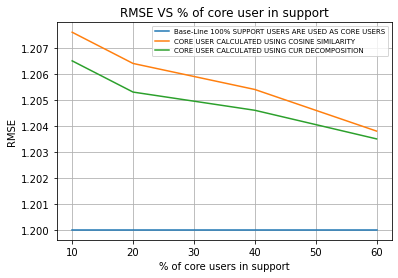

In [25]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60]
y_axis = [1.2076, 1.2064, 1.2054, 1.2038]
x1_axis = [10, 20, 40, 60]
y1_axis = [1.2000, 1.2000, 1.2000, 1.2000]
x2_axis = [10, 20, 40, 60]
y2_axis = [1.2065, 1.2053, 1.2046, 1.2035]

plt.plot(x1_axis, y1_axis, label="Base-Line 100% SUPPORT USERS ARE USED AS CORE USERS")
plt.plot(x_axis, y_axis, label="CORE USER CALCULATED USING COSINE SIMILARITY")
plt.plot(x2_axis, y2_axis, label="CORE USER CALCULATED USING CUR DECOMPOSITION")

plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend(fontsize=7)
plt.show()